# Rainfall Data | Exploratory Data Analysis and Binary Prediction Model
Business Task: Use the rainfall dataset to predict rainfall for each day of the year

Evaluation Metric: Models are evaluated on Area Under the Receiver Operating Characteristic Curve (AUC-ROC) between the predicted probability and the observed target.

AUC-ROC is used over other likelihood evaluation methods because it doesn't depend on a probability threshold, and remains reliable even when one of the events are rare (e.x. rainfall)

# Dataset Overview

## Import Libraries

In [33]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Matplotlib defaults
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [34]:
def load_data():
    # Read data
    data_dir = Path("./")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    df_test['winddirection'].fillna(df_test['winddirection'].median(), inplace=True)
    return df_train, df_test

# Preprocessing
## Clean Data

In [35]:
def clean(df):
    # Remove whitespace from columns (if there is any)
    df.columns = df.columns.str.strip()
    # Fix typo in temparature column
    df.rename(columns={
        "temparature": "temp",
    }, inplace=True,
    )
    return df

In [36]:
df_train, df_test = load_data()

# Exploratory Data Analysis
## Dataset Observations:
### Dataset Shape
- Training Data: 2190 rows, 13 columns
- Test Data: 730 rows, 12 columns (Missing rainfall, which will be modeled)
### Missing Values
- No missing values in training dataset
- `winddirection` feature has one missing value (will be imputed)
### Key Data Observations
- ID: Used as index column
- Day: 1-365, days of the year
- Pressure: Ranges from 999 to 1034.6 hPa.(hPa = Hectopascal. The standard pressure at sea-level is 1013.25 hPa)
- Temperature Features: Max temp (10.4°C - 36.0°C), Min temp (4.0°C - 29.8°C), and Average temp for the day.
- Dew Point: Ranges from -0.3°C to 26.7°C. (dew point is the temperature point at which the air can hold no more water vapor and is one of the factors in the heat index. A dew point of between 10°C to 15°C is most comfortable, higher becomes uncomfortable due to the air's inability to hold more water (i.e. sweat)
- Humidity: Ranges from 39% to 98%.(The amount of water vapor in the air)
- Cloud Cover: Ranges from 2% to 100%.
- Sunshine Duration: Ranges from 0 to 12.1 hours.
- Wind Speed: Ranges from 4.4 km/h to 59.5 km/h.
- Wind Direction: Further investigation required. Most values are whole numbers, multiples of ten, but some do not adhere to this trend. Ranges from 10 to 300.
- Rainfall: Binary target variable (0 = No Rain, 1 = Rain).
### Summary Stats
- Pressure: Mean: 1013.6 hPa, Min: 999.0, Max: 1034.6.
- Max Temperature: Mean: 26.36°C, Min: 10.4°C, Max: 36.0°C.
- Min Temperature: Mean: 22.17°C, Min: 4.0°C, Max: 29.8°C.
- Dew Point: Mean: 20.45°C, Min: -0.3°C, Max: 26.7°C.
- Humidity: Mean: 82.03%, Min: 39%, Max: 98%.
- Cloud Cover: Mean: 75.72%, Min: 2%, Max: 100%.
- Sunshine: Mean: 3.74 hours, Min: 0 hours, Max: 12.1 hours.
- Wind Speed: Mean: 21.8 km/h, Min: 4.4 km/h, Max: 59.5 km/h.
- Rainfall: Mean: 0.75, indicating ~75% rainy days in the dataset.

### Key Takeaways
- High variance in cloud cover and humidity suggests their importance in predicting rainfall.
- Rainfall distribution is imbalanced (~75% rainy days), which should be considered in modeling.

## Visual Analysis

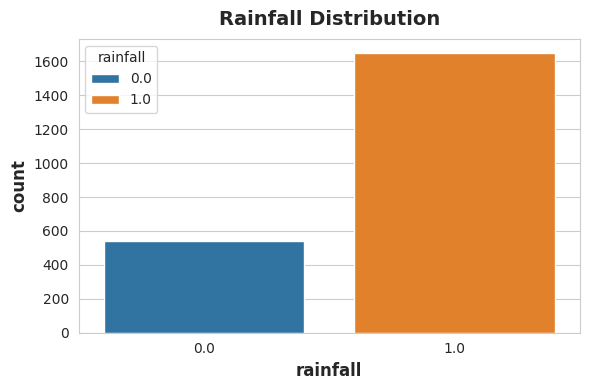

In [37]:
# Visual illustrating rainfall imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x=df_train['rainfall'], hue=df_train['rainfall'])
plt.title("Rainfall Distribution")
plt.show()

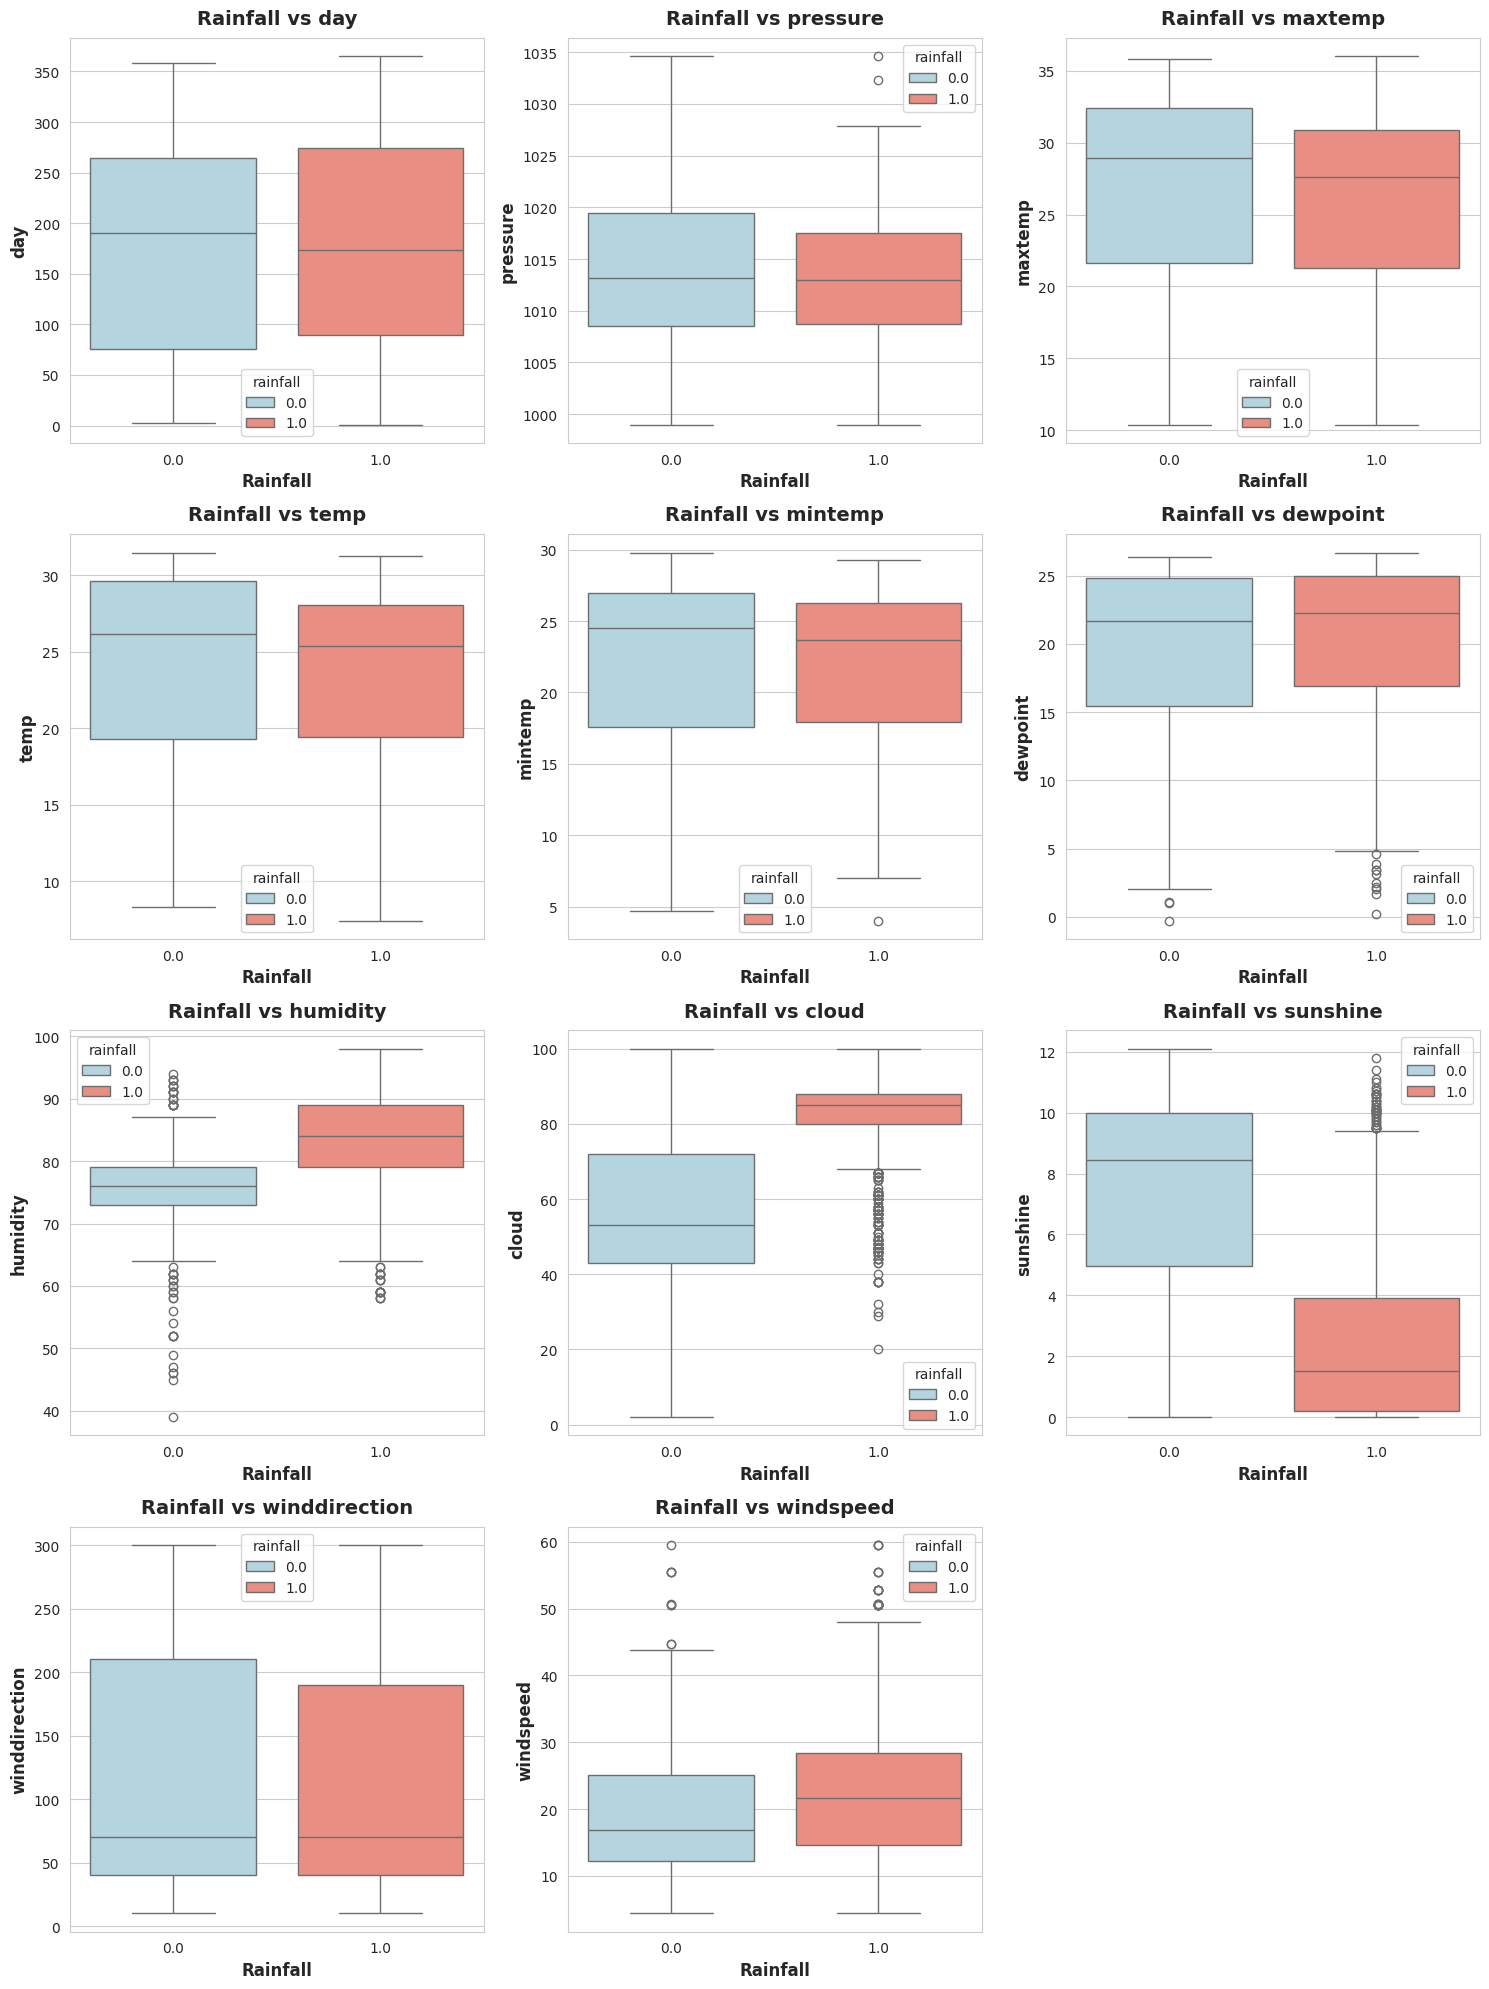

In [38]:
def create_numerical_plots(numerical_cols):
    num_features = len(numerical_cols)
    cols = 3  # Number of subplots per row
    rows = int(np.ceil(num_features / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        sns.boxplot(
            data=df_train, 
            x='rainfall', 
            y=col, 
            hue='rainfall', 
            ax=axes[i],
            palette={0.0: "lightblue", 1.0: "salmon"}  # Different color for each rainfall category
        )
        axes[i].set_title(f"Rainfall vs {col}")
        axes[i].set_xlabel("Rainfall")
        axes[i].set_ylabel(col)
        

    # If there are empty subplots (when total numeric columns not multiple of 'cols'), remove them
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

numerical_cols = df_train.select_dtypes("number").columns.drop('rainfall')
create_numerical_plots(numerical_cols)

## Bivariate Analysis
Next, we'll measure the correlation between each independent variable/feature. This is done to see if there is significant overlap between features.

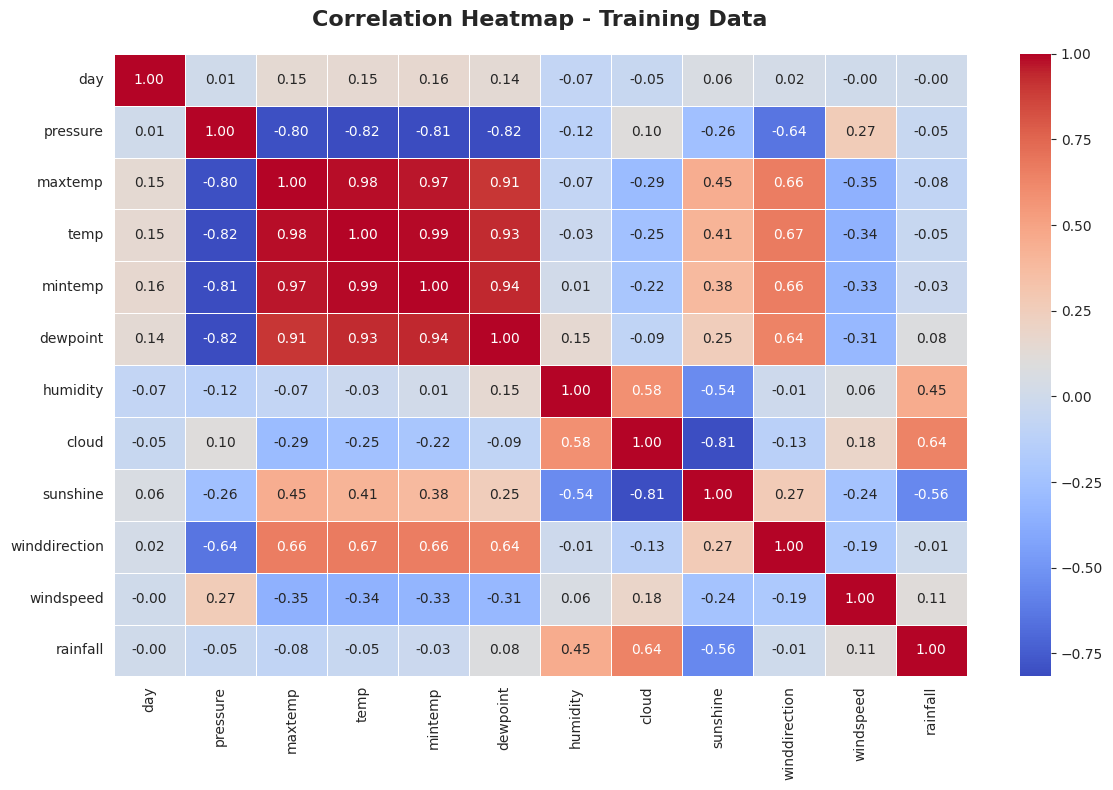

In [39]:
data_corr = df_train.corr()

# Create a mask for the upper triangle
#mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data_corr, cmap='coolwarm', linewidths=.5, annot=True, fmt=".2f")

# Add title
plt.title("Correlation Heatmap - Training Data", fontsize=16, pad=20)

# Adjust layout and display
plt.tight_layout()
plt.show()

### Key Insights
1. `maxtemp`, `temperature`, and `mintemp` are highly correlated (~.97 to .99)
   - Consider feature selection/PCA to reduce dimensionality
2. `dewpoint` and `humidity` are positively correlated (~.68 to .69)
3. `cloud` and `sunshine` are negatively correlated (~-.65 to .66)
4. `pressure` and `humidity` are moderately negatively correlated (~-0.29 to -0.30)
5. `windspeed` and `cloud` are weakly negatively correlated (~-0.19 to -0.24)
6. `temperature` and `humidity` are weakly positively correlation (~0.15).
7. `winddirection` and `windspeed` are moderately positively correlation (~0.19 to 0.21).

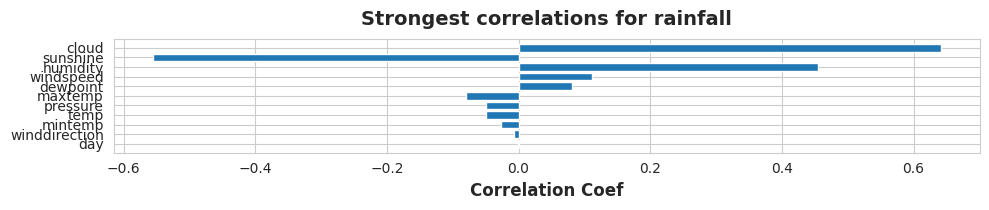

In [40]:
def make_rainfall_corr(df):
    # Calculate correlation for each column against 'rainfall'
    corr_series = pd.get_dummies(df).corr()['rainfall']
    # Sort by absolute value (descending)
    rainfall_corr = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index).drop('rainfall')
    return rainfall_corr

def display_corr(rainfall_corr):
    plt.figure(figsize=(10, len(rainfall_corr)/5))
    plt.barh(rainfall_corr.index, rainfall_corr.values)
    plt.xlabel('Correlation Coef')
    plt.title("Strongest correlations for rainfall")
    plt.gca().invert_yaxis()  # To show the most important features at the top
    plt.show()
    

rainfall_corr = make_rainfall_corr(df_train)
display_corr(rainfall_corr)

## Feature Engineering

In [41]:
def day_to_month(day_of_year):
    if day_of_year <= 31:
        return 1  # January
    elif day_of_year <= 59:
        return 2  # February
    elif day_of_year <= 90:
        return 3  # March
    elif day_of_year <= 120:
        return 4  # April
    elif day_of_year <= 151:
        return 5  # May
    elif day_of_year <= 181:
        return 6  # June
    elif day_of_year <= 212:
        return 7  # July
    elif day_of_year <= 243:
        return 8  # August
    elif day_of_year <= 273:
        return 9  # September
    elif day_of_year <= 304:
        return 10  # October
    elif day_of_year <= 334:
        return 11  # November
    else:
        return 12  # December

In [42]:
# Let's create some features
# Interaction features
def create_interaction_features(df): 
    df['tempRange'] = df['maxtemp'] - df['mintemp']
    df['dewpointDiff'] = df['dewpoint'] - df['temp']
    df['humidTempRatio'] = df['humidity'] / (df['temp'] + 1)
    df['dewHumidInteraction'] = df['dewpoint'] * df['humidity']
    df['sunshineCloudRatio'] = df['sunshine'] / (df['cloud'] + 1)
    df['cloudHumidityInteraction'] = df['humidity'] * df['cloud']
    df['humiditySunshineRatio'] = df['sunshine'] / (df['humidity'] + 1)
    df['windspeedDiff'] = df['windspeed'] - df['windspeed'].shift(1).fillna(0)
    return df

# Encode features
def encode_features(df):
    df['season'] = pd.cut(df['day'], bins=[0, 60, 150, 240, 330, 365], 
                                  labels=['Winter', 'Spring', 'Summer', 'Fall', 'Winter'], 
                                  include_lowest=True, ordered=False)
    
    df['cardinalWD'] = pd.cut(df['winddirection'], bins=[0, 45, 135, 225, 315, 360], 
                                      labels=['North', 'East', 'South', 'West', 'North'], 
                                      include_lowest=True, ordered=False)
    
    df['month'] = df['day'].apply(day_to_month)
    df['WS_categories'] = pd.cut(df['windspeed'], bins=[0, 15, 25, 65],
                                 labels=['Low', 'Medium', 'High'],
                                 include_lowest=True)
    return df

def rolling_lagging_features(df, window=3, span=7):
    cols = ['temp', 'sunshine', 'cloud', 'humidity']
    for col in cols:
        df[f'rolling_avg_{col}'] = df[f'{col}'].rolling(window=window).mean().fillna(0)
        df[f'{col}_lag_1'] = df[f'{col}'].shift(1).fillna(0)
        df[f'ema_{col}'] = df[f'{col}'].ewm(span=span, adjust=False).mean().fillna(0)
    return df
    

In [43]:
# Training on uninformative features can lead to overfitting
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [44]:
def compute_mutual_information(X, y):
    X_encoded = X.copy()
    
    # Encode object/categorical features
    for col in X_encoded.select_dtypes(['object', 'category']):
        X_encoded[col], _ = X_encoded[col].factorize()

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X_encoded, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X_encoded.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

def plot_mutual_information(mi_series):
    mi_series.sort_values().plot(kind='barh', title='Mutual Information with Survival')
    plt.xlabel('Mutual Information')
    plt.tight_layout()
    plt.show()

In [80]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("rainfall")
    
    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("rainfall")
        X = pd.concat([X, X_test])

    X = create_interaction_features(X)
    X = encode_features(X)
    X = rolling_lagging_features(X)
    #print(X.columns)

    
    # Lesson 2 - Mutual Information
    #mi_scores = compute_mutual_information(X, y)
    #X = drop_uninformative(X, mi_scores)
    
    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    if df_test is not None:
        return X, X_test
    else:
        return X

    

In [63]:
df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "rainfall"]

## Scoring Dataset

In [64]:
def score_dataset(X, y, model=XGBClassifier()):
    for colname in X.select_dtypes(['object', "category"]):
        X[colname] = X[colname].cat.codes
    #X_encoded = pd.get_dummies(X)
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    #roc_auc = roc_auc_score(y, model.predict_proba(X)[:, 1])
    score = cross_val_score(
        model, X, y, cv=5, scoring="roc_auc",
    )
    return score.mean()

In [65]:
baseline_score = score_dataset(X, y)
print(f"Baseline AUC-ROC: {baseline_score:.5f}")

Baseline AUC-ROC: 0.87237


# Creating the Model

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Grid Search Fun!

In [67]:
# Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10], # Regularization Strength
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=0), param_grid_lr, cv=5, scoring='roc_auc')
grid_search_lr.fit(X_train.drop(columns=['month', 'day']), y_train)

print("Best parameters for Logistic Regression", grid_search_lr.best_params_)

Best parameters for Logistic Regression {'C': 0.001, 'max_iter': 100, 'solver': 'liblinear'}


In [68]:
# Random Forest Classifier
param_dist_rf = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_dist_rf,
                                    n_iter=2, #Changed to 25 for speed, originally 150 but LR was still best model
                                    cv=5, 
                                    scoring='roc_auc',
                                    #verbose=2,
                                    n_jobs=-1,
                                    random_state=0)

random_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", random_search_rf.best_params_)

Best parameters for Random Forest: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [69]:
# XGBClassifier
param_dist_xgb = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [.01, .05, .1],
    'max_depth': [3, 6, 10, 15],
    'subsample': [.8, .9, 1],
    'colsample_bytree': [.7, .8, 1],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, .5, 1],
    'reg_lambda': [0, 0.1, .5, 1]
}

random_search_xgb = RandomizedSearchCV(XGBClassifier(random_state=0), param_dist_xgb, 
                                    n_iter=2, #Changed to 25 for speed, originally 150 but LR was still best model
                                    cv=5, 
                                    scoring='roc_auc',
                                    #verbose=2,
                                    n_jobs= -1,
                                    random_state=0)
                                
random_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBClassifier:", random_search_xgb.best_params_)

Best parameters for XGBClassifier: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1}


In [70]:
def display_evaluation(model):
    # Get Predictions
    preds = model.predict(X_test)

    # Get Auc-roc if it has it
    if hasattr(model, "predict_proba"):  # Not all models have predict_proba
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"AUC-ROC: {roc_auc:.4f}")

    # Classification report
    print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(f"Classification Report:")
    print(classification_report(y_test, preds))

In [71]:
#Test the models with optimal hyperparameters
models = {
    "Logistic Regression": grid_search_lr.best_estimator_,
    "Random Forest": random_search_rf.best_estimator_,
    "XGBClassifier": random_search_xgb.best_estimator_,
}

for name, model in models.items():
    # Annoying error; Even though they were fit when tuning hyperparameters, my whiny models wanted to be tuned again
    # So be it!!
    model.fit(pd.get_dummies(X_train), y_train)
    print(f"Training model: {name}\n" + "-"*30)
    display_evaluation(model)

Training model: Logistic Regression
------------------------------
AUC-ROC: 0.8932
Accuracy: 0.8630
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.62      0.71       116
         1.0       0.87      0.95      0.91       322

    accuracy                           0.86       438
   macro avg       0.85      0.79      0.81       438
weighted avg       0.86      0.86      0.86       438

Training model: Random Forest
------------------------------
AUC-ROC: 0.8913
Accuracy: 0.8721
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.68      0.74       116
         1.0       0.89      0.94      0.92       322

    accuracy                           0.87       438
   macro avg       0.85      0.81      0.83       438
weighted avg       0.87      0.87      0.87       438

Training model: XGBClassifier
------------------------------
AUC-ROC: 0.8816
Accuracy: 0.8653
Classificati

In [72]:
catboost = CatBoostClassifier(random_state=0, verbose=False)

catboost.fit(pd.get_dummies(X_train), y_train)
print(f"Training model: Catboost\n" + "-"*30)
display_evaluation(catboost)

Training model: Catboost
------------------------------
AUC-ROC: 0.8914
Accuracy: 0.8721
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.70      0.74       116
         1.0       0.90      0.93      0.91       322

    accuracy                           0.87       438
   macro avg       0.84      0.82      0.83       438
weighted avg       0.87      0.87      0.87       438



# Model Evaluation

In [73]:
best_model = catboost

In [74]:
# Check if the model has feature_importances_ attribute
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    importance_type = 'Feature Importance'
else:
    # For logistic regression, use coefficients as importance
    feature_importance = np.abs(best_model.coef_[0])
    importance_type = 'Coefficient Magnitudes'

# Create a DataFrame to combine feature names and their importance values
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the features by importance in descending order
feature_df = feature_df.sort_values(by='Importance', ascending=False)

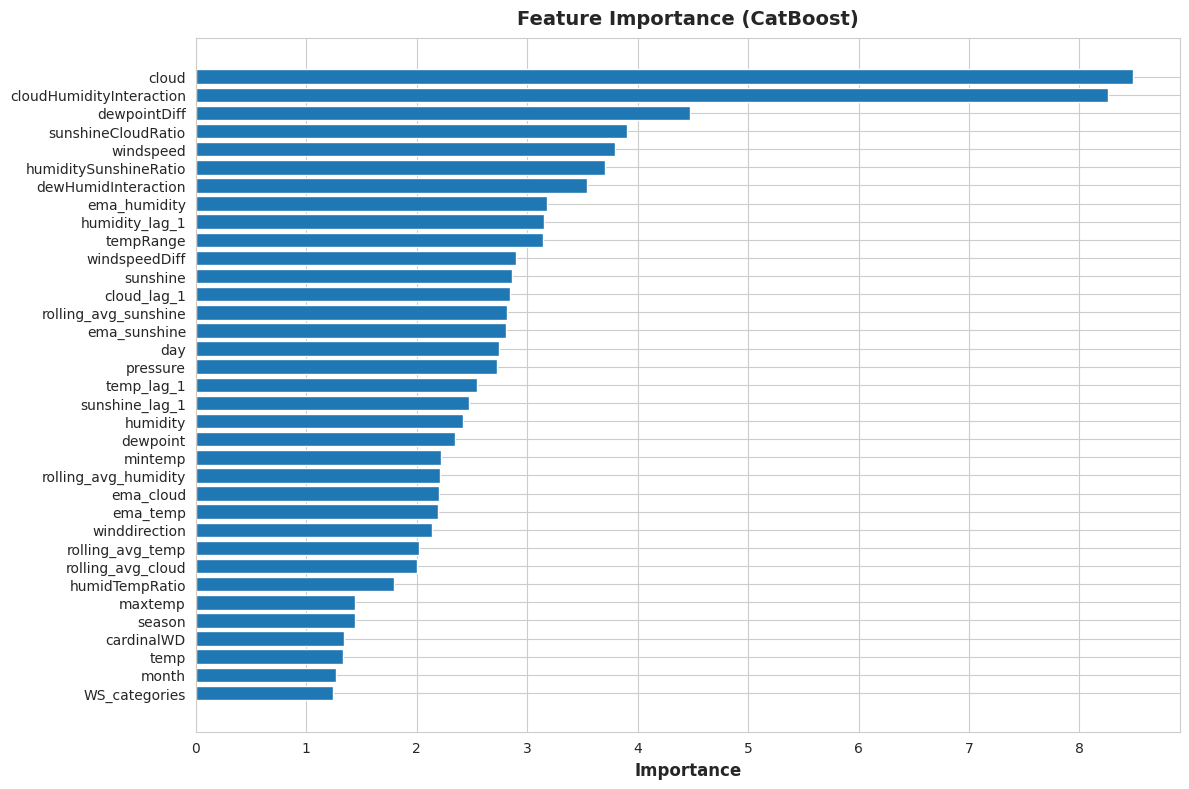

In [75]:
# Visualize Feature Importance

plt.figure(figsize=(12, 8))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (CatBoost)')
plt.gca().invert_yaxis()  # To show the most important features at the top
plt.show()

## Cross-Validation

In [76]:
scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')

print(scores)
print("%0.2f roc-auc average with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.86380471 0.91116723 0.90429293 0.89130191 0.87188552]
0.89 roc-auc average with a standard deviation of 0.02


In [77]:
# Train the model on ALL the data
best_model.fit(X, y)

# Submission

In [81]:
df_test = create_features(df_test)
# Whoops! Make sure to predict proba, not just predict.
predictions = best_model.predict_proba(df_test)[:, 1]
submission = pd.DataFrame({'id': df_test.index, 'rainfall': predictions})
submission.to_csv('submission.csv', index=False)
display(submission)

CatBoostError: features data: pandas.DataFrame column 'season' has dtype 'category' but is not in  cat_features list

Credit to [this notebook](https://www.kaggle.com/code/tarundirector/rainfall-pred-eda-clean-ai-news#%5B3%5D-%F0%9F%92%A1-Exploratory-Data-Analysis-(EDA)) for inspiration